In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')

from ffball_getData import ffball_data

QB_data = ffball_data('QB')
#for weeks in range(2,11):
#    QB_data.update(weeks)

#QB_data.save_df()

Change coding of bye week; one hot encoding for home-away; interaction effects; remove no opponent; code teams for prediction by looping through team names; try a gamma link; yahoo?

In [2]:
#axs = pd.tools.plotting.scatter_matrix(QB_data.ix[:,-8:], figsize=(6,6), diagonal='kde');
#[ax.set_yticks([]) for ax in axs[:,0]] #turn off the ticks that take up way too much space in such a crammed figure
#[ax.set_xticks([]) for ax in axs[-1,:]];

So I want past performance to influence current predictions and both of them to influence the predicted variable. Is this possible? I am not sure about the time thing. It seems like it should be part of the model, but I am uncertain about how to include it. I should also probably have the matchup in the model. There is nothing about matchup in this model and that would be helpful. How to get that data and how exactly to give it to the model is a mystery...

Ok, then there is the thing of making player specific predictions, but hopefully every prediction is more or less as good for each different player, So while the predictions are player specific, the error is shared across the players. 

I am having trouble seeing the big picture here, so I will just start with a stupid linear model and go from there.

$$Actual = a_{[i]j}*x + eta$$
 


                 Generalized Linear Model Regression Results                  
Dep. Variable:            cbs_actual2   No. Observations:                  747
Model:                            GLM   Df Residuals:                      699
Model Family:                Gaussian   Df Model:                           47
Link Function:               identity   Scale:                    19.723653825
Method:                          IRLS   Log-Likelihood:                -2148.9
Date:                Sun, 20 Nov 2016   Deviance:                       13787.
Time:                        16:49:39   Pearson chi2:                 1.38e+04
No. Iterations:                     4                                         
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0586      0.092     -0.640      0.522        -0.238     0.121
x2             0.1899      0.149      1.272      0.2

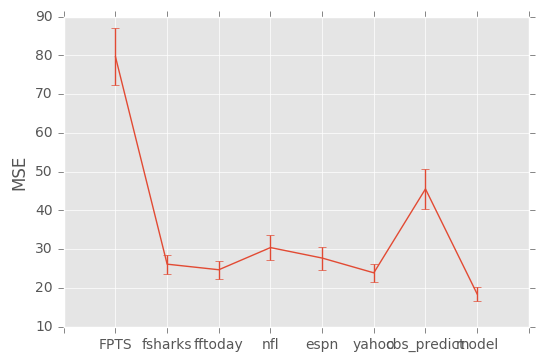

In [4]:
import statsmodels.api as sm
import math

QB_df = QB_data.load_df()
all_teams = QB_df.pop('opp')
team_enc = pd.get_dummies(all_teams)
team_enc.pop(0)
home_away = pd.get_dummies(QB_df.pop('home_away'))
home_away.columns = ['bye_inj','away','home']
QB_df = pd.concat([QB_df,team_enc,home_away],axis=1)
QB_df['bye_inj'] = np.double(QB_df['bye_inj'] == 0)
#QB_df = QB_df[QB_df['player_num']<35]
data_endo = QB_df.pop('cbs_actual2')
data_exo = QB_df.ix[:,5:].values
data_exo[:,:17] = data_exo[:,:17]*np.tile(data_exo[:,-3],(17,1)).T
data_exo = sm.add_constant(data_exo, prepend=False)


glm_gamma = sm.GLM(data_endo, data_exo, family=sm.families.Gaussian())
glm_results = glm_gamma.fit()
print(glm_results.summary())

MSE,STE = [],[]
predicting_sites = ['FPTS','fsharks','fftoday','nfl','espn','yahoo','cbs_predict']
for num,predictors in enumerate(predicting_sites):
    SE = [(x-data_endo.values[i])**2 for i,x in enumerate(QB_df[predictors].values)]
    MSE.append(sum(SE)/len(SE))
    STE.append(np.std(SE)/math.sqrt(len(SE)))
    #plt.plot(num,MSE)
SE = [(glm_results.predict(x)-data_endo.values[i])**2 for i,x in enumerate(data_exo)]
MSE.append(sum(SE)/len(SE))
STE.append(np.std(SE)/math.sqrt(len(SE)))

plt.errorbar(np.arange(0,8),MSE,yerr=STE);
plt.xlim(-1,8);
plt.ylabel('MSE')
plt.xticks(np.arange(-1,9),['']+predicting_sites+['model']+['']);

In [5]:
QB_pred_df = QB_data.update(11,pred=True);
team_enc = QB_pred_df.pop('opp')

team_list = np.unique(all_teams[all_teams!=0])
team_mat = pd.DataFrame(np.zeros((np.shape(QB_pred_df)[0],len(team_list))),columns=team_list)
for teams in team_list:
    match_index = np.where(team_enc==teams)
    if len(match_index)>0: team_mat[teams].ix[match_index] = 1
    
home_away = pd.get_dummies(QB_pred_df.pop('home_away'))
home_away.columns = ['bye_inj','away','home']
QB_pred_df = pd.concat([QB_pred_df,team_mat,home_away],axis=1)
QB_pred_df['bye_inj'] = np.double(QB_pred_df['bye_inj'] == 0)

pred_df = QB_pred_df[QB_pred_df['week']==11].ix[:,:3]

data_exo = QB_pred_df[QB_pred_df['week']==11].ix[:,5:].values
data_exo[:,:17] = data_exo[:,:17]*np.tile(data_exo[:,-3],(17,1)).T
data_exo = sm.add_constant(data_exo, prepend=False)

predicted_perf = [glm_results.predict(x)[0] for x in data_exo]
pred_df['predicted_points'] = predicted_perf
pred_df.sort_values('predicted_points',ascending=False)

,FirstName,LastName,Team,predicted_points
0,Cam,Newton,CAR,30.834317
6,Ben,Roethlisberger,PIT,22.895674
7,Kirk,Cousins,WAS,21.951479
4,Drew,Brees,NO,21.737187
1,Tom,Brady,NE,20.867042
9,Blake,Bortles,JAC,20.211135
17,Colin,Kaepernick,SF,20.176852
2,Andrew,Luck,IND,20.030794
19,Jameis,Winston,TB,18.151417
10,Andy,Dalton,CIN,18.026586


So I have individual players across all the weeks. One thing that I want to do is to use past performance to predict future performance, but how to do this is confusing... also I feel like I should have a heirarchy somewhere, but where is unclear. 

Ok. So maybe this is the best way to think about it. Every player has a true mean and sd for scoring and these truths exert influence on the predictions and past performance, and then observed behavior is drawn from this. Then there are things that modulate his true mean like who the opponent is. 

In [ ]:
import pystan

pooled_model = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""


pooled_data_dict = {'N': len(data_endo),
               'x': QB_data.yahoo.values,
               'y': data_endo.values}

pooled_fit = pystan.stan(model_code=pooled_model, data=pooled_data_dict, iter=1000, chains=2)

In [ ]:
pooled_sample = pooled_fit.extract(permuted=True)
b0, m0 = pooled_sample['beta'].T.mean(1)


plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--')

In [ ]:
import pystan
schools_code = """
data {
    int<lower=0> J; // number of schools
    real y[J]; // estimated treatment effects
    real<lower=0> sigma[J]; // s.e. of effect estimates
}
parameters {
    real mu;
    real<lower=0> tau;
    real eta[J];
}
transformed parameters {
    real theta[J];
    for (j in 1:J)
    theta[j] <- mu + tau * eta[j];
}
model {
    eta ~ normal(0, 1);
    y ~ normal(theta, sigma);
}
"""

schools_dat = {'J': 8,
               'y': [28,  8, -3,  7, -1,  1, 18, 12],
               'sigma': [15, 10, 16, 11,  9, 11, 10, 18]}

fit = pystan.stan(model_code=schools_code, data=schools_dat,
                  iter=1000, chains=4)

In [29]:
season=2016
pos_dict = {'QB':10, 'RB':20, 'WR':30, 'TE':40, 'K':80}
league_dict = {'fftoday':1,'fft_ppr':107644,'yahoo':17,'FFPC':107437,'NFFC':5}
week=2
position='QB'

urls = dict()
urls['fftoday'] = "http://www.fftoday.com/rankings/playerwkproj.php?Season=%d&GameWeek=%d&PosID=%d&LeagueID=%d"\
    % (season,week,pos_dict[position],league_dict['fft_ppr'])

keys = 'fftoday'
df = pd.read_html(urls[keys],match='FFPts',header=16)[0]